In [87]:
import pandas as pd

# Load CSV file
# df0 = pd.read_csv('AprilChurnPredictions.csv')
df0 = pd.read_csv('churn_predictions_with_ValueSegment.csv')
# print(df.head())

# Decode encoded valuesegment columns
# segment_columns = df0.filter(like='ValueSegment').columns
# df0['ValueSegment'] = df0[segment_columns].idxmax(axis=1)
# df0['ValueSegment'] = df0['ValueSegment'].apply(lambda x: x.split('_')[1])

# df0.drop(columns=segment_columns, inplace=True)
# print(df.head())
# print(df.dtypes)
# print(df.isnull().sum())

df = df0[['Customer_id', 'ChurnProbability', 'ValueSegment']]
# df.rename(columns={'value_segment': 'ValueSegment'}, inplace=True)
# df.rename(columns={'churn_probability': 'ChurnProbability'}, inplace=True)

df.rename(columns={'ChurnProbability': 'Pi'}, inplace=True)

"""
# According to the bank's 3-month definition
df = pd.read_csv("filtered_threemonths_churn.csv")
df.rename(columns={'Churn': 'Pi'}, inplace=True)
"""

base_acceptance_rates = {
    'A1': 0.015,
    'A2': 0.018,
    'B': 0.02,
    'C': 0.025,
    'D': 0.030
}
df['Ai'] = df['ValueSegment'].map(base_acceptance_rates)

E_values = {
    'C1': 0.6,
    'C2': 1,
    'C3': 1.8
}

vi_values = {
    # 'A1': 5663.92,
    # 'A2': 3026.86,
    # 'B': 1464.43,
    # 'C': 383.67,
    # 'D': 250
        'A1': 22558.55,
        'A2': 1894.69,
        'B': 824.30,
        'C': 215.28,
        'D': 27.79
    
}

df['Vi'] = df['ValueSegment'].map(vi_values)

print(df.head())

   Customer_id   Pi ValueSegment     Ai        Vi
0     97425734  0.0           A1  0.015  22558.55
1     97425700  0.0            B  0.020    824.30
2     97425673  0.0            D  0.030     27.79
3     97425610  0.0            C  0.025    215.28
4     97425607  0.0            B  0.020    824.30


In [88]:
# df = df.head(20000)
# df = df.sample(n=20000, random_state=42)
row_count = df.shape[0]
print("DataFrame row count:", row_count)


DataFrame row count: 51169


In [89]:
import pandas as pd
import pulp as pl

M = 400000
B = 924/1283
D = 2290/2422

# campaign_costs = {'C1': 50, 'C2': 100, 'C3': 200}
campaign_costs = {'C1': 75, 'C2': 125, 'C3': 250}

# PuLP model
model = pl.LpProblem("Customer_Retention_Optimization", pl.LpMaximize)

# Decision Variables 
# key: (customer_id, campaign)
x_vars = {(i, c): pl.LpVariable(f"x_{i}_{c}", cat='Binary')
          for i in df['Customer_id'] for c in campaign_costs.keys()}

# # If no campaign is sent:
for var in x_vars.values():
    model += var == 0

# Objective Function
# max z = ΣI ΣC Vi [(Pi * B * 0.5)((Xic * Aic) - (1 - Xic)) + (1 - Pi) * D] - ΣI ΣC Xic * Cc * Aic

model += pl.lpSum([
    df.loc[df['Customer_id'] == i, 'Vi'].values[0] * (
        (df.loc[df['Customer_id'] == i, 'Pi'].values[0] * B * 0.5) * 
        (x_vars[i, c] * df.loc[df['Customer_id'] == i, 'Ai'].values[0] * E_values[c] - (1 - x_vars[i, c])) + 
        (1 - df.loc[df['Customer_id'] == i, 'Pi'].values[0]) * D)
         - x_vars[i, c] * df.loc[df['Customer_id'] == i, 'Ai'].values[0] * E_values[c] * campaign_costs[c] for i in df['Customer_id'].unique() for c in campaign_costs
])

# budget constraint
total_cost = pl.lpSum([x_vars[(row['Customer_id'], c)] * campaign_costs[c] for index, row in df.iterrows() for c in campaign_costs.keys()])

budget_constraint = pl.LpConstraint(e=total_cost, sense=pl.LpConstraintLE, rhs=M, name="BudgetConstraint")

model += budget_constraint

# At most one campaign to one customer
for i in df['Customer_id']:
    model += pl.lpSum(x_vars[i, c] for c in campaign_costs) <= 1

status = model.solve()

# Check if the solution was successful

if status == pl.LpStatusOptimal:
    print("Model solved successfully.")
    total_gain_or_cost = model.objective.value()
    formatted_total = f"{total_gain_or_cost:,.2f}"
    print("Total gain:", formatted_total)
else:
    print("Model could not be solved. Status:", pl.LpStatus[status])

Model solved successfully.
Total gain: 167,768,220.58


Unique CustomerID count: 51169

               Count Percentage
ValueSegment                  
C             25099     %49.05
B             15521     %30.33
D              4640      %9.07
A2             4140      %8.09
A1             1769      %3.46 



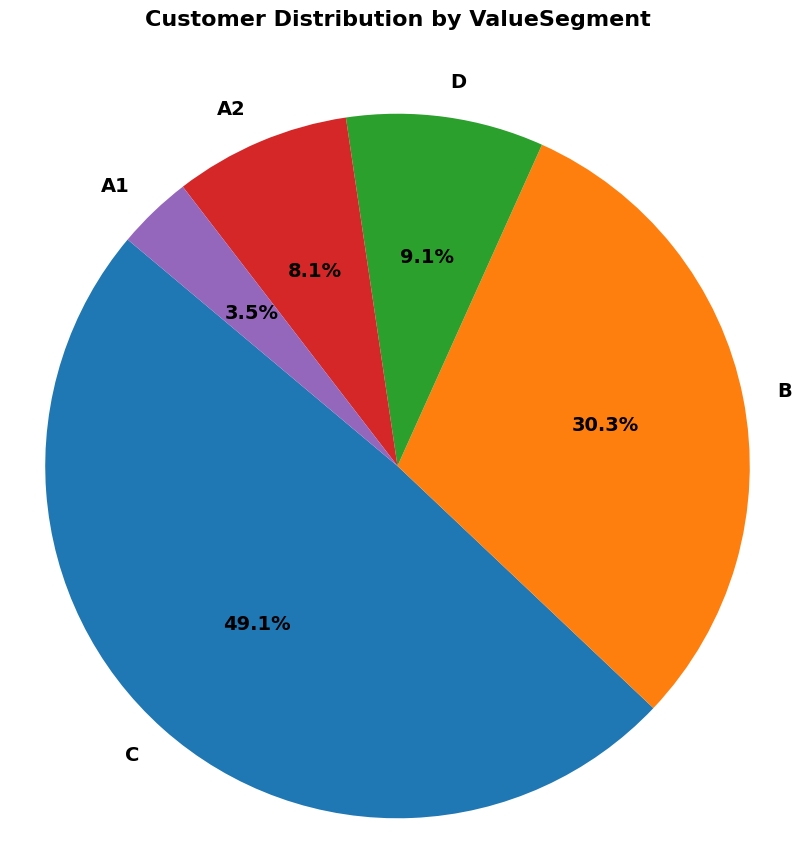

Send Campaign count: 0 

Total spending: 0

Shadow Price Value: -0.0


In [90]:
# Customer numbers by their segments
unique_customer_count = df['Customer_id'].nunique()
print("Unique CustomerID count:", unique_customer_count)

segment_counts = df['ValueSegment'].value_counts()
segment_percentages = df['ValueSegment'].value_counts(normalize=True) * 100
segment_percentages = segment_percentages.apply(lambda x: f"%{x:.2f}")
segment_summary = pd.DataFrame({'Count': segment_counts, 'Percentage': segment_percentages})
print("\n", segment_summary, "\n")

import matplotlib.pyplot as plt

# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title('Customer Distribution by ValueSegment', fontsize=16, weight='bold', pad=40)  # Adjust the padding to move the title

# Display the pie chart
plt.axis('equal')
plt.show()


results = []

# Collect results for each customer and campaign from the x_vars dictionary
for (customer_id, campaign), var in x_vars.items():
    results.append({
        'Customer_id': customer_id,
        'Campaign': campaign,
        'Decision': 'Send Campaign' if var.value() == 1 else 'Do Not Send Campaign'
    })

results_df = pd.DataFrame(results)
results_df = results_df.merge(df[['Customer_id', 'ValueSegment']], on='Customer_id', how='left').drop_duplicates()

# Print the number of campaigns sent and the corresponding dataframe
decision_counts = results_df['Decision'].value_counts()
print("Send Campaign count:", decision_counts.get('Send Campaign', 0), "\n")
# print(results_df)

# Finding the total campaign spending
total_spending = 0

for (customer_id, campaign), var in x_vars.items():
    if pl.value(var) == 1:
        total_spending += campaign_costs[campaign]

print("Total spending:", total_spending)
print("\nShadow Price Value:", model.constraints["BudgetConstraint"].pi)

In [91]:
# from IPython.display import display, HTML
# pd.set_option('display.max_rows', 100)
# display(HTML(results_df.to_html(index=False)))

In [92]:
# not_sent_indices = results_df[results_df['Decision'] != 'Send Campaign'].index

# print("Kampanya gönderilmeyen müşterilerin indeksleri:")
# print(not_sent_indices.tolist())

In [93]:
# Filtering the DataFrame
filtered_df = results_df[(results_df['ValueSegment'] == 'D') & (results_df['Decision'] == 'Send Campaign')]

# Counting the number of unique Customer_id
count = filtered_df['Customer_id'].nunique()

print(count)

0


In [94]:
# Print sent campaigns based on campaign type and segment
send_campaign_df = results_df[results_df['Decision'] == 'Send Campaign']
campaign_segment_stats = send_campaign_df.groupby(['Campaign', 'ValueSegment']).size().unstack(fill_value=0)

campaign_segment_stats['Total'] = campaign_segment_stats.sum(axis=1)
campaign_segment_stats.loc['Total'] = campaign_segment_stats.sum()

# Calculating and formatting percentages
total_count = campaign_segment_stats.loc['Total', 'Total']
percentage_df = campaign_segment_stats.div(total_count).multiply(100).round(2).astype(str) + '%'

# Adding percentages next to numbers
for col in campaign_segment_stats.columns:
    campaign_segment_stats[col] = campaign_segment_stats[col].astype(str) + ' (' + percentage_df[col] + ')'

print("Sent campaign counts and percentages by campaign and segment:")
campaign_segment_stats

Sent campaign counts and percentages by campaign and segment:


ValueSegment,Total
Campaign,
Total,0.0 (nan%)


In [95]:
import matplotlib.pyplot as plt
import numpy as np

campaign_segment_counts = send_campaign_df.groupby(['Campaign', 'ValueSegment']).size().unstack(fill_value=0)

# Draw a separate pie chart for each segment
for segment in campaign_segment_counts.columns:
    fig, ax = plt.subplots()
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.8, len(campaign_segment_counts.index)))
    wedges, texts, autotexts = ax.pie(campaign_segment_counts[segment], labels=campaign_segment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    for text in texts:
        text.set_color('black')
        text.set_fontweight('bold')
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    ax.set_title(f'Campaign Distribution for Segment {segment}')
    plt.show()

In [96]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt

# Calculating segment distribution
segment_counts = df['ValueSegment'].value_counts()
print(segment_counts)

segment_distribution = send_campaign_df['ValueSegment'].value_counts()
print(segment_distribution)

# Using a color map with normalized values
norm = plt.Normalize(min(segment_distribution), max(segment_distribution))
colors = plt.cm.Blues(np.linspace(0.25, 0.75, len(segment_distribution)))
label_props = {'fontsize': 12, 'fontweight': 'bold'}  # Font size and thickness for labels

# Pie graph
plt.figure(figsize=(4, 3))
plt.pie(segment_distribution, labels=segment_distribution.index, autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
        startangle=140, colors=colors, textprops=label_props, pctdistance=0.75)
plt.title('Distribution of Segments Among Customers Who Received Campaign', fontsize=14, fontweight='bold')
plt.show()

ValueSegment
C     25099
B     15521
D      4640
A2     4140
A1     1769
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


ValueError: min() iterable argument is empty